In [11]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np
import math

Скопируем код из предыдущего задания

In [12]:
# Реализуем класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [13]:
# И класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [14]:
# Класс дерева
class Tree:

    def __init__(self, max_params = 40, max_depth=40, criteria = "gini"):
        self.max_params = max_params
        self.max_depth = max_depth
        self.criteria = criteria
        if criteria == 'entropy':
            self.criteriaFunc = self.entropy
        else:
            self.criteriaFunc = self.gini
        
        self.params = []
        
    # Обучение
    def fit(self, data, labels):
        self.tree = self.build(data, labels)
        return self.tree
    
    # предсказание
    def predict(self, data):
    
        classes = []
        for obj in data:
            prediction = self.classify(obj, self.tree)
            classes.append(prediction)
        return classes
        
    # Построение дерева
    def build(self, data, labels, depth=1):
        
        # останов по глубине дерева
        if depth>self.max_depth:
            return Leaf(data, labels)
        
        quality, t, index = self.find_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return Leaf(data, labels)
        
        # добавляем признак
        if not(index in self.params):
            self.params.append(index)
            
        # останов по использованным признакам
        if len(self.params)>self.max_params:
            return Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build(true_data, true_labels, depth+1)
        false_branch = self.build(false_data, false_labels, depth+1)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)
    
    # Нахождение наилучшего разбиения
    def find_split(self, data, labels):
        #  обозначим минимальное количество объектов в узле
        min_leaf = 5

        current_crit = self.criteriaFunc(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < min_leaf or len(false_data) < min_leaf:
                    continue

                current_quality = self.quality(true_labels, false_labels, current_crit)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index
    
    # Разбиение датасета в узле
    def split(self, data, labels, index, t):

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    # предсказание
    def classify(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify(obj, node.true_branch)
        else:
            return self.classify(obj, node.false_branch)
        
    # Расчет качества
    def quality(self, left_labels, right_labels, current_crit):

        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return current_crit - p * self.criteriaFunc(left_labels) - (1 - p) * self.criteriaFunc(right_labels)
    
    # критерий Джини
    def gini(self, labels):
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2
        return impurity
    
    # критерий Энтропии
    def entropy(self, labels):
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        impurity = 0
        for label in classes:
            p = classes[label] / len(labels)
            if p!=0:
                impurity -= p * math.log(p, 2)
        return impurity

In [24]:
# визуализируем сгенерированные данные
def displayData(classification_data, classification_labels):
    colors = ListedColormap(['red', 'blue'])
    light_colors = ListedColormap(['lightcoral', 'lightblue'])

    plt.figure(figsize=(8,8))
    plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
                  c=classification_labels, cmap=colors)

---

#### Задание 1.

*Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50, 100, 200 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.*

---

Для начала добавим два класса RandomTree, который будет обучаться на подвыборке из признаков и RandomForest, который будет содержать несколько таких деревьев

In [44]:
# Класс случайного дерева с парой переопределенных методов
class RandomForestTree (Tree):
    
    # отбираем признаки для обучения
    def subsample(self, featuresCnt):
        # будем сохранять не сами признаки, а их индексы
        sample_indexes = [i for i in range(featuresCnt)]
        
        
        len_subsample = int(np.sqrt(featuresCnt)) 
        subsample = []

        random.shuffle(sample_indexes)
        for _ in range(len_subsample):
            subsample.append(sample_indexes.pop())

        return subsample
    
    # Нахождение наилучшего разбиения
    def find_split(self, data, labels):
        #  обозначим минимальное количество объектов в узле
        min_leaf = 5

        current_crit = self.criteriaFunc(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]
        
        # выбор индекса из подвыборки длиной sqrt(n_features)
        subsample = self.subsample(n_features)

        for index in subsample:
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < min_leaf or len(false_data) < min_leaf:
                    continue

                current_quality = self.quality(true_labels, false_labels, current_crit)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index
    
    

In [45]:
# Класс случайных деревьев
class RandomForest:
    
    def __init__(self, tree_count=10, max_params = 40, max_depth=40, criteria = "gini"):
        self.forest = []
    
        for i in range(0,tree_count):
            tree = RandomForestTree(max_params, max_depth, criteria);
            self.forest.append(tree)
    
    # Обучение
    def fit(self, data, labels):
        
        bootstrap = self.bootstrap(data, labels, len(self.forest))
        
        for tree in self.forest:
            b_data, b_labels = bootstrap.pop()
            tree.fit(b_data, b_labels)
    
    # предсказание
    def predict(self, data):
        predictions = []
        for tree in self.forest:
            predictions.append(tree.predict(data))
            
        # сформируем список с предсказаниями для каждого объекта
        predictions_per_object = list(zip(*predictions))

        # выберем в качестве итогового предсказания для каждого объекта то,
        # за которое проголосовало большинство деревьев
        voted_predictions = []
        for obj in predictions_per_object:
            voted_predictions.append(max(set(obj), key=obj.count))
        
        return voted_predictions
    
    # случайное разбиение
    def bootstrap(self, data, labels, N):
        n_samples = data.shape[0]
        bootstrap = []

        for i in range(N):
            b_data = np.zeros(data.shape)
            b_labels = np.zeros(labels.shape)

            for j in range(n_samples):
                sample_index = random.randint(0, n_samples-1)
                b_data[j] = data[sample_index]
                b_labels[j] = labels[sample_index]
            bootstrap.append((b_data, b_labels))

        return bootstrap

In [46]:
classification_data, classification_labels = datasets.make_classification(n_samples=1000,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

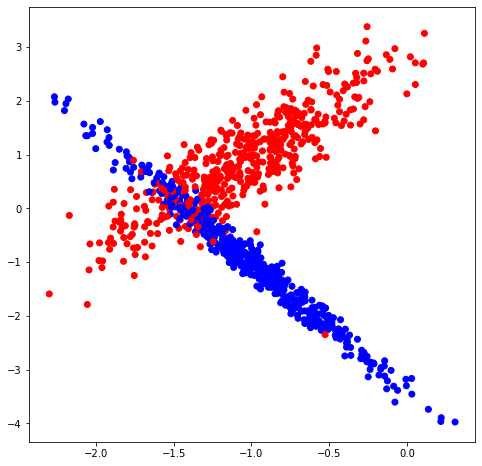

In [47]:
displayData(classification_data,classification_labels)

In [48]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [57]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [77]:
trees = []

for i in [1, 3, 10, 50, 100]:
    rf = RandomForest(tree_count = i, max_depth=5)
    rf.fit(train_data, train_labels)
    predict_train = rf.predict(train_data)
    predict = rf.predict(test_data)
    
    accuracy_train = accuracy_metric(train_labels, predict_train)
    accuracy_test = accuracy_metric(test_labels, predict)
    trees.append([rf, accuracy_train, accuracy_test])
    
    print('Точность при количестве деревьев '+str(i)+': '+str(accuracy_train)+' / '+str(accuracy_test))

Точность при количестве деревьев 1: 91.42857142857143 / 88.33333333333333
Точность при количестве деревьев 3: 93.28571428571428 / 89.33333333333333
Точность при количестве деревьев 10: 94.57142857142857 / 91.66666666666666
Точность при количестве деревьев 50: 95.71428571428572 / 93.0
Точность при количестве деревьев 100: 95.57142857142857 / 92.66666666666666


In [79]:
# Визуализируем дерево на графике
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def showTree(train_data, train_labels, train_accuracy, test_data, test_labels, test_accuracy, tree):

    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

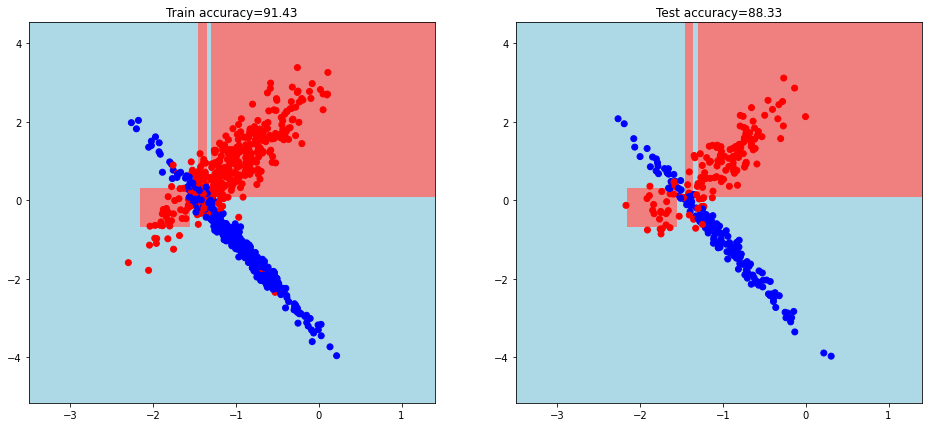

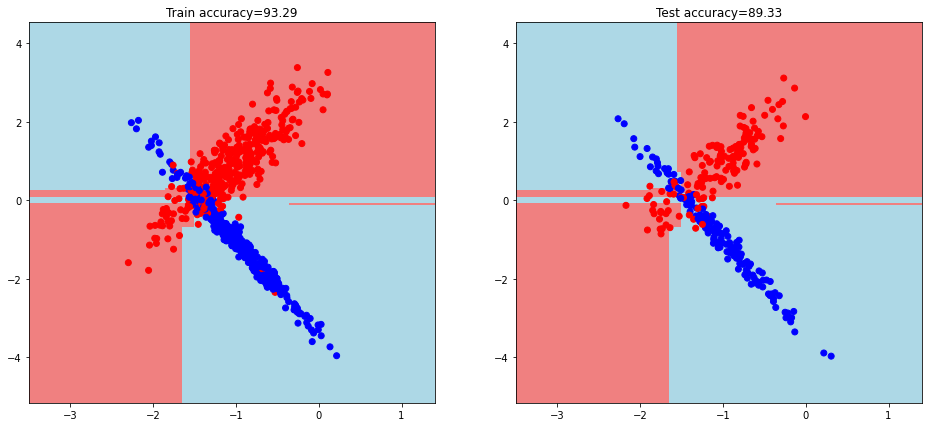

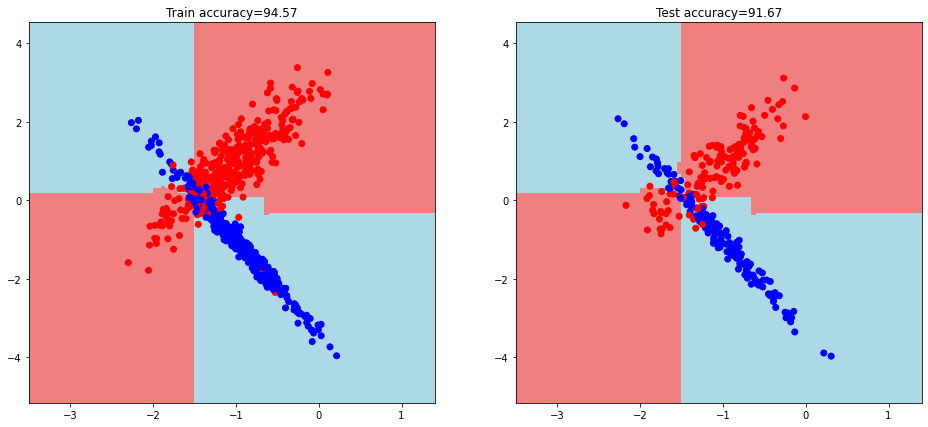

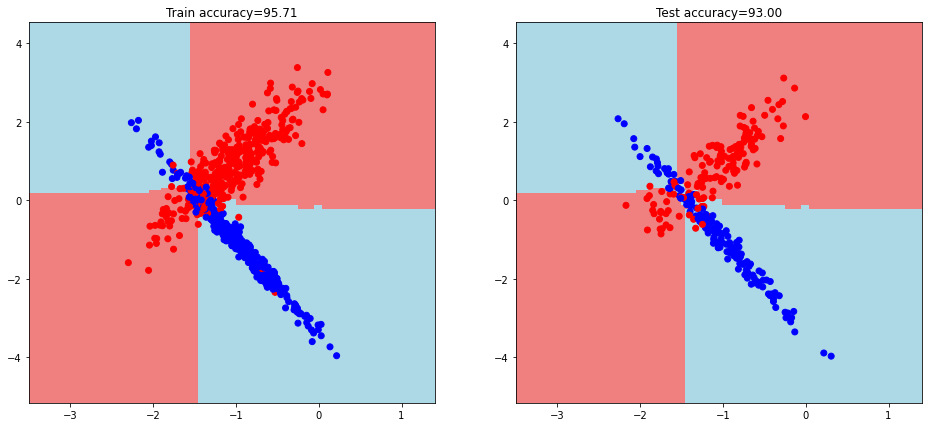

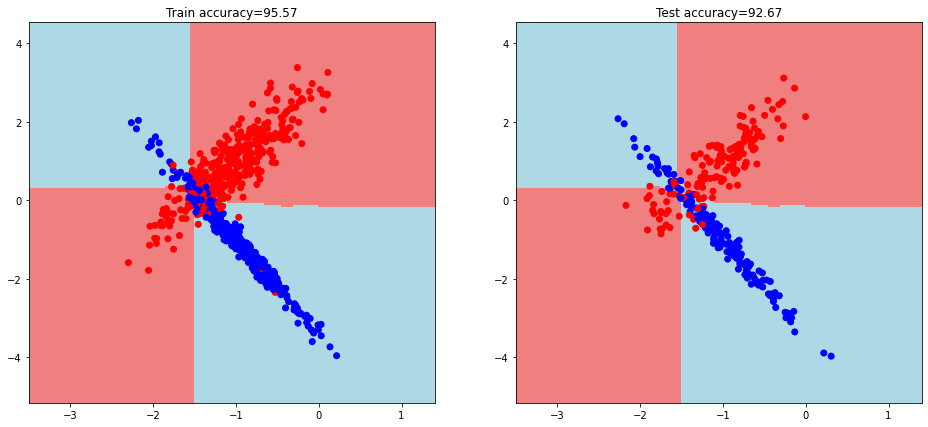

In [80]:
for (tree, train_accuracy, test_accuracy) in trees:
    showTree(train_data, train_labels, train_accuracy, test_data, test_labels, test_accuracy, tree)

Графики получились довольно хорошие. На одиночном дереве, очевидно, недообучение, но с увеличением количества деревьев оно проходит и на последнем графике модель похожа на хорошо обученную без переобучения.

---
#### Задание 2. 

*Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.*

---

In [134]:
# Класс случайных деревьев
class RandomForestOOB(RandomForest):
    # Обучение
    def fit(self, data, labels):
        
        self.out = []
        self.data = data
        self.labels = labels
        
        bootstrap = self.bootstrap(data, labels, len(self.forest))
        
        for tree in self.forest:
            b_data, b_labels, out_data = bootstrap.pop()
            tree.fit(b_data, b_labels)
            self.out.append((out_data, tree.predict(b_data)))
            
            
    # случайное разбиение
    def bootstrap(self, data, labels, N):
        n_samples = data.shape[0]
        bootstrap = []
        
        out_data = np.ones(data.shape[0])

        for i in range(N):
            b_data = np.zeros(data.shape)
            b_labels = np.zeros(labels.shape)

            for j in range(n_samples):
                sample_index = random.randint(0, n_samples-1)
                b_data[j] = data[sample_index]
                b_labels[j] = labels[sample_index]
                out_data[sample_index] = 0
            bootstrap.append((b_data, b_labels, out_data))

        return bootstrap
    
    # рассчитываем OOB
    def calcOOB(self):
        error = 0
        for i in range(len(self.data)):
            cnt = 0
            errs = 0
            for (out_data, predict) in self.out:
                if out_data[i]:
                    cnt += 1
                    if self.labels[i]!=predict[i]:
                        errs += 1
            if cnt>0:
                error += errs / cnt
        
        return error

In [135]:
trees = []

for i in [1, 3, 10, 50, 100]:
    rf = RandomForestOOB(tree_count = i, max_depth=5)
    rf.fit(classification_data, classification_labels)
    predict = rf.predict(classification_data)
    
    accuracy = accuracy_metric(classification_labels, predict)
    print('Точность при количестве деревьев '+str(i)+': '+str(accuracy))
    print('out-of-bag error: '+str(rf.calcOOB()))

Точность при количестве деревьев 1: 90.0
out-of-bag error: 176.0
Точность при количестве деревьев 3: 90.4
out-of-bag error: 25.666666666666664
Точность при количестве деревьев 10: 93.4
out-of-bag error: 0
Точность при количестве деревьев 50: 94.3
out-of-bag error: 0
Точность при количестве деревьев 100: 94.89999999999999
out-of-bag error: 0
